Тетрадка - вариант решения тестового задания. ТГ для связи: https://t.me/Serge_koval

## Основная часть

Использование встроенного в Open_CV функционала не дало достаточного качества, пришлось использовать внешние библиотеки. Кстати, и распознавание текста из цветного изображения проходит, на мой взгляд, получше, чем ч/б.

In [ ]:
!pip install easyocr

In [ ]:
!pip install mtcnn

В качестве "якорной точки" ориентируемся на наличие фото. Другие элементы в качестве шаблона не очень подходят. Распознать "Российская Федерация" можно только после детекции, - а присутствует не всегда. Проблеммы и с номером по правому борту.

In [ ]:
# cv
import cv2
import PIL
import numpy as np
from mtcnn import MTCNN
import easyocr

# general
import os
import string
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
CURRENT = "current.png"
letters = "".join([chr(x) for x in range(ord('а'), ord('я') + 1)]) + 'ё'
CHARS = letters + letters.upper() + string.digits + '.'
reader = easyocr.Reader(["ru"])
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
detector = MTCNN()

 
class NotFacesFoundError(Exception):
    pass

class NameNotFoundError(Exception):
    pass


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.1% Complete

In [ ]:
# здесь функции, используемые и для демо-части и для пользовательской 

def save_masked(im, mask, filename=CURRENT):
    saved_img = cv2.bitwise_and(im, im, mask=mask)
    cv2.imwrite(filename, saved_img)
    return saved_img


def check_coord(c, tr_h, w_c):
    h, w, x_c = c[3][1] - c[0][1], c[1][0] - c[0][0], (c[0][0] + c[1][0]) / 2
    return (h > 0.8 * tr_h) and (w_c - 2 * w < x_c < w_c + 2 * w)


def get_text_result(textes, tr_conf=0.5):
    res = []
    tr = []  # собираем высоту боксов (ориентируемся на 3 самых высоких), центры по горизонтали

    for coord, text, confidence in textes:
        words = [word.upper() for word in text.split() if word.isalpha()]  # ["WORD_A", "WORD_B"]
        if words and confidence > tr_conf:
            tr.append((coord[3][1] - coord[0][1], (coord[0][0] + coord[1][0]) / 2))
            res.append((coord, words[0]))  # Для этого варианта только 1 слово
    
    if len(res) < 3:
        raise  NameNotFoundError
    
    tr.sort(reverse=True)
    tr_h = tr[2][0] if len(tr) > 2 else sum([h for h, x in tr[:3]]) / 3
    w = [x_c for h, x_c in tr]
    w.sort()
    w_c = sum(w[:3]) / 3

    res = [pair for pair in res if check_coord(pair[0], tr_h, w_c)]    # отбросили те, что ниже порога
    res = sorted(sorted(res, key=lambda pair: pair[0][0][0]), key=lambda pair: pair[0][0][1])   # "Y" по возрастанию ("Х" по возрастанию)

    keys = ("Фамилия", "Имя", "Отчество")
    answer = {key: val[-1] for key, val in zip(keys, res)}
    if len(answer) == 3:
        return answer
    raise NameNotFoundError


def get_faces_coord_cnn(im_colored, x_min, y_min, x_max, y_max):
    " MTCNN coord , - возвращаем 1 box"
    res = detector.detect_faces(im_colored)
    boxes = [item.get('box') for item in res]
    if boxes:
        return boxes[0]
 
    raise NotFacesFoundError(boxes, x_min, y_min, x_max, y_max)


def get_mask(shape, x1, y1, x2, y2):
    mask = np.zeros(shape[:2], np.uint8)
    cv2.rectangle(mask, pt1=(x1, y1), pt2=(x2, y2), color=255, thickness=-1)
    return mask


def erose_border(img):
    corners = np.uint0(cv2.goodFeaturesToTrack(img, 20, 0.05, 200))
    x_min, y_min = img.shape
    x_max, y_max = 0, 0
    for corner in corners:
        x, y = corner.ravel()
        x_min, y_min = min(x_min, x), min(y_min, y)
        x_max, y_max = max(x_max, x), max(y_max, y)

    mask = get_mask(img.shape, x_min, y_min, x_max, y_max)
    img = cv2.bitwise_and(img, img, mask=mask)

    return img, (x_min, y_min, x_max, y_max)


def save_crop_text(im, x, y, w, h, filename, denoiser=None):
    # рассчет координат для окна с ФИО"
    x1, y1 = x + int(1.9 * w), y - int(1.29 * h)
    x2, y2 = x + int(7.6 * w), y + h - int(0.33 * h)
    if denoiser:
        pass
        # маскирование фото
        mask1 = get_mask(im.shape, int(x - 0.2 * w), int(y - 0.2 * h), int(x + 1.2 * w), int(y + 1.2 * h)) 
        im = cv2.bitwise_or(im, im, mask=mask1)
        im = denoiser(im)

    mask2 = get_mask(im.shape[:2], x1, y1, x2, y2)  
    return save_masked(im, mask2, filename)


def best_ocr(temp_file):
    text = reader.readtext(temp_file, 
                           decoder='beamsearch', 
                           contrast_ths=0.25, 
                           allowlist=CHARS,           # возможно ведет к переобучению
                           min_size=15)
    return text


def convert_image2text(image_file, temp_file=CURRENT, ocr_func=best_ocr):
    img_c = cv2.imread(image_file)
    img_c = cv2.cvtColor(img_c, cv2.COLOR_BGR2RGB)   # на цветном даже лучше не только фото искать, но и OCR отрабатывает хорошо.
    img = cv2.cvtColor(img_c, cv2.COLOR_BGR2GRAY)

    #  Определим точки внешнего контура,- не дать внешнему контуру внести смещение в denoising
    img, (x_min, y_min, x_max, y_max) = erose_border(img)

    # фотография будет служить привязкой для окна, в котором ищем ФИО
    x, y, w, h = get_faces_coord_cnn(img_c, x_min, y_min, x_max, y_max)   # NotFacesFoundError!!
    cv2.rectangle(img, (x, y), (x + w, y + h), 0, 3)

    # выделяем и сохраняем целевой сегмент
    cropp = save_crop_text(img_c, x, y, w, h, filename=temp_file, denoiser=None)

    text = ocr_func(temp_file)
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 18))
    ax[0].imshow(img, cmap='gray', vmin=0, vmax=255)
    ax[1].imshow(cropp, cmap='gray', vmin=0, vmax=255)
    plt.show()

    return text


## Эта часть относится к боту,- раз просили API.
И поскольку цели чисто тестовые - самая простая из библиотек.

In [ ]:
!pip install pytelegrambotapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 213 kB 5.3 MB/s 
  Created wheel for pytelegrambotapi: filename=pyTelegramBotAPI-4.7.1-py3-none-any.whl size=196987 sha256=835a44695aecec0d90bd6983748a29ce4a6404926544daa9fe91b16b1cd30466
  Stored in directory: /root/.cache/pip/wheels/84/72/5f/8a7b3ca1ef1250002cf3bac48e0c72c5ee5c9596a5b1295dc1
Successfully built pytelegrambotapi


In [ ]:
from io import BytesIO
from telebot import types
from telebot import TeleBot
import requests
from telebot import apihelper
import logging
from tele_token import  TOKEN     # файл с токеном



def store_photo_id(bot, message, image_files):
    # нужно получить  картинки, поэтому будем сохранять id  картинки в словарь
    chat_id = message.chat.id
    # получаем информацию о картинке , сохраняем photo_Id   за пользователем
    image_id = message.photo[-1].file_id
    print('Obtained file_obj = ', image_id)
    image_files[chat_id] = image_id
    

def save_photo(bot, image_id, file_name):
    image_file_obj = bot.get_file(image_id)
    image_file = bot.download_file(image_file_obj.file_path)

    # bytes переводим в Image и далее в тензор
    image_file = BytesIO(image_file)
    image_file.seek(0)
    image = PIL.Image.open(image_file)
    print("image_shape", image.size)
    image.save(file_name)


def main_bot():
    image_files = {}  
    logging.basicConfig(
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        level=logging.INFO)

    bot = TeleBot(TOKEN)
    command = "прочитать ФИО по скану"

    markup_menu = types.ReplyKeyboardMarkup(resize_keyboard=True, row_width=3)  
    markup_menu.add(types.KeyboardButton(command))


    @bot.message_handler(commands=['start', 'help'])
    def send_welcome(message: types.Message):
        text = ""
        if message.text == "/start":
            text = "У бота только одна опция: прочитать ФИО по скану паспорта"
        elif message.text == "/help":
            text = "простой последовательный бот для парсинга ФИО"
        bot.send_message(message.chat.id, text, reply_markup=markup_menu) 
            

    @bot.message_handler(content_types=['photo'])
    def photo(message):
        store_photo_id(bot, message, image_files)


    @bot.message_handler(func=lambda message: True)
    def send_welcome(message: types.Message):
        text_template = "отправьте скан паспорта, страница с текстом должна располагаться горизонтально"
        chat_id = message.chat.id
        file_name = str(chat_id) + ".png"

        if message.text == command:
            if chat_id in image_files:
                bot.send_message(chat_id, 
                                     "Файл получен, обработка займет несколько минут",
                                     reply_markup=markup_menu
                                    )
                try:
                    save_photo(bot, image_files[chat_id], file_name)
                    texts = convert_image2text(file_name) 
                    answer = get_text_result(texts)  
                    print("OK! answer=", answer) 
                    text = "\n".join([f"{key}: {val}" for key, val in answer.items()])
                    bot.send_message(chat_id, 
                                     text,
                                     reply_markup=markup_menu
                                    )
                except NotFacesFoundError:
                    bot.send_message(chat_id, 
                                     "Возможно это скан, и даже скан паспорта, но бот не смог его распознать\n" + text_template,
                                     reply_markup=markup_menu
                                    )
                except NameNotFoundError as e:
                    print("NameNotFoundError <> file_name, texts:", file_name, texts)
            else:
                bot.send_message(chat_id, 
                                 "Сначала " + text_template,
                                 reply_markup=markup_menu
                                )
        else:
            bot.send_message(chat_id, 
                                f'{message.text} -что это было???',
                                reply_markup=markup_menu
                                )

    bot.polling(none_stop=True, timeout=60)

Запускать бота здесь (раскомментировать):

In [ ]:
# main_bot()

## Демо- часть.

Пример обработки тестовых сканов. Не все читаются хорошо. В примере понизил порог уверенности до 0.3, но правильнее говорить "Не знаю" при большем пороге . Также есть сомнение в полезности allow_list - возможно достовернее было бы избежать подгонки и отбрасывать не литеральные ответы.

In [ ]:
filenames = []
for filename in sorted(os.listdir(os.getcwd())):
    if filename.endswith('.jpeg') or filename.endswith('.png'):
        filenames.append(filename)
", ".join(filenames)

'0.jpeg, 1.jpeg, 2.jpeg, 3.jpeg, 4.png, 5.jpeg, 6.jpeg, 7.jpeg, 8.jpeg, 9.jpeg'

1/1 [==============================] - 0s 36ms/step


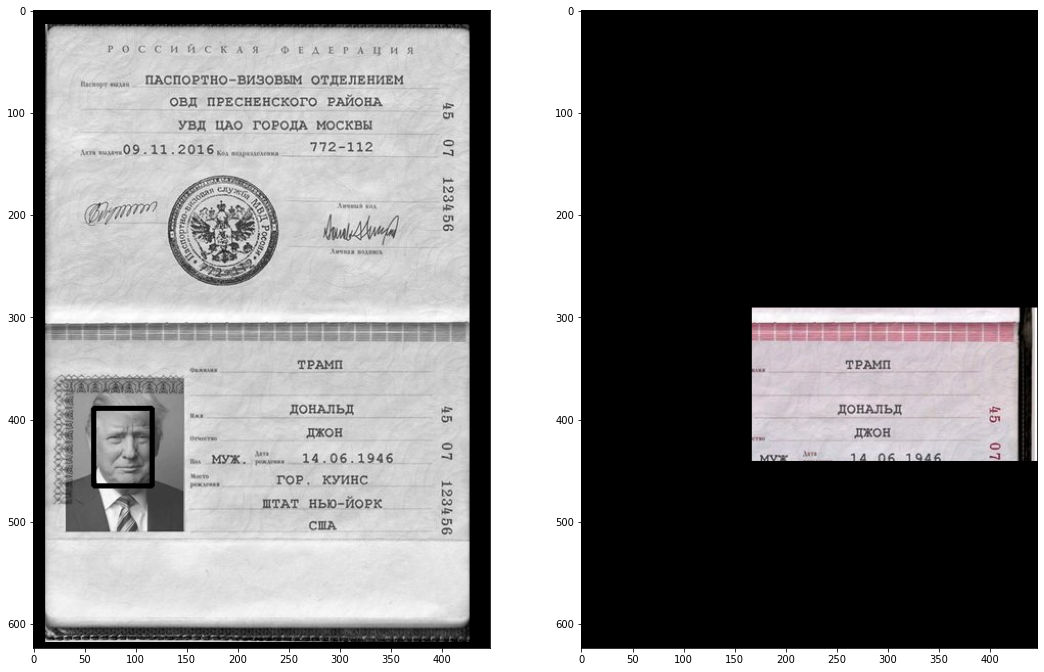

OK! answer= {'Фамилия': 'ТРАМП', 'Имя': 'ДОНАЛЬД', 'Отчество': 'ДЖОН'}
----------------------------------------
1/1 [==============================] - 0s 32ms/step


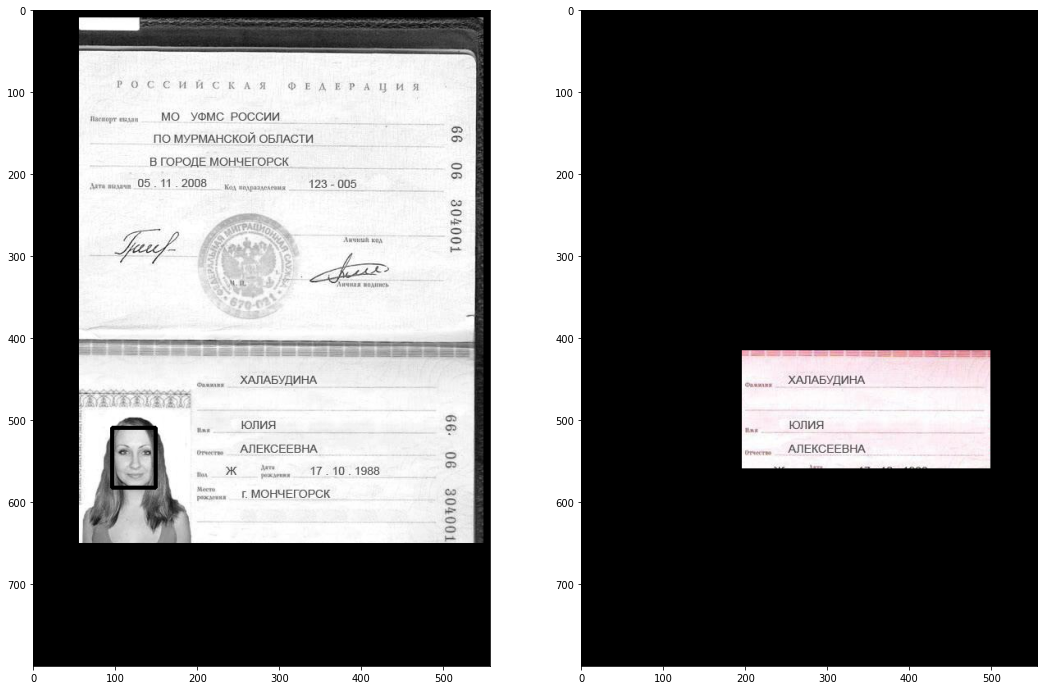

OK! answer= {'Фамилия': 'ХАЛАБУДИНА', 'Имя': 'ЮЛИЯ', 'Отчество': 'АЛЕКСЕЕВНА'}
----------------------------------------
1/1 [==============================] - 0s 35ms/step


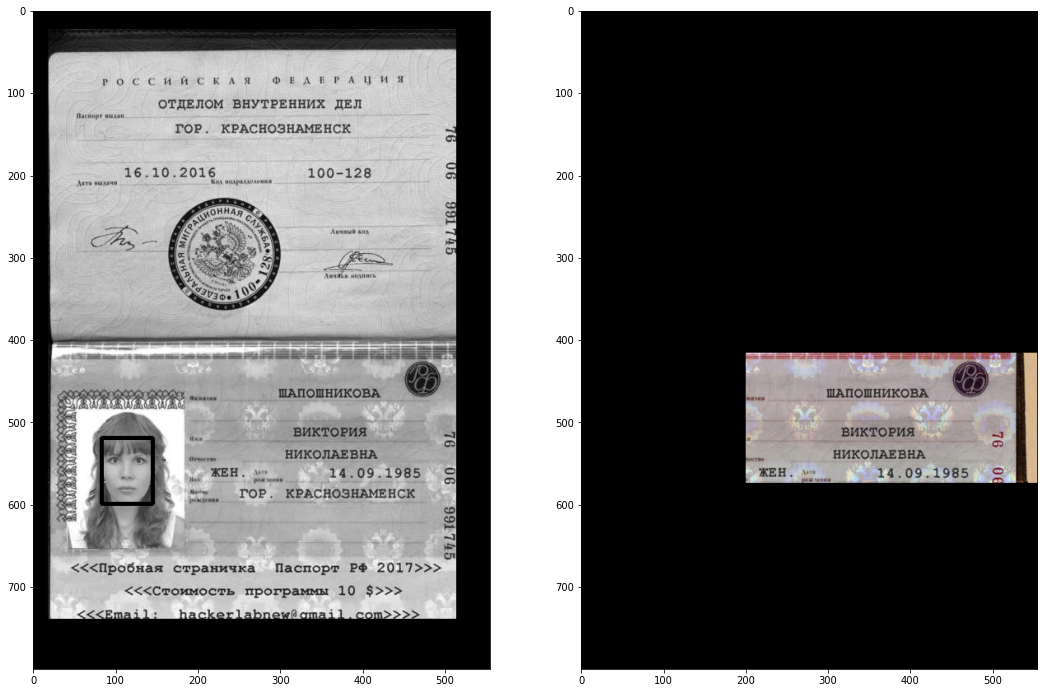

OK! answer= {'Фамилия': 'ШАПОШНИКОВА', 'Имя': 'ВИКТОРИЯ', 'Отчество': 'НИКОЛАЕВНА'}
----------------------------------------
1/1 [==============================] - 0s 29ms/step


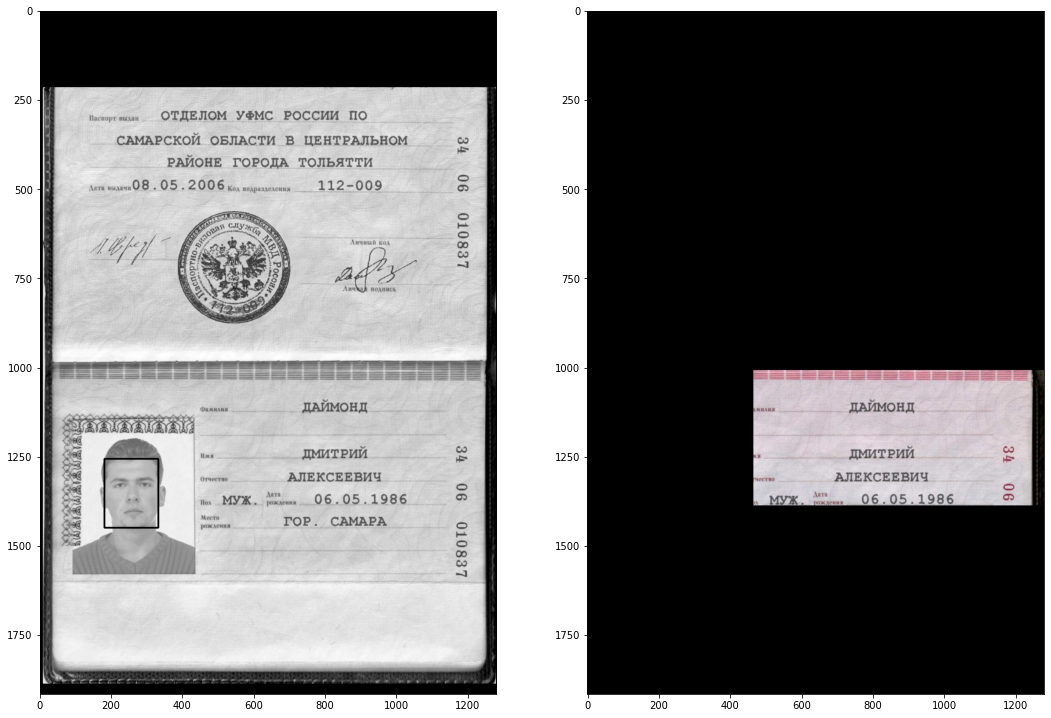

OK! answer= {'Фамилия': 'ДАЙМОНД', 'Имя': 'ДМИТРИЙ', 'Отчество': 'АЛЕКСЕЕВИЧ'}
----------------------------------------
1/1 [==============================] - 0s 28ms/step


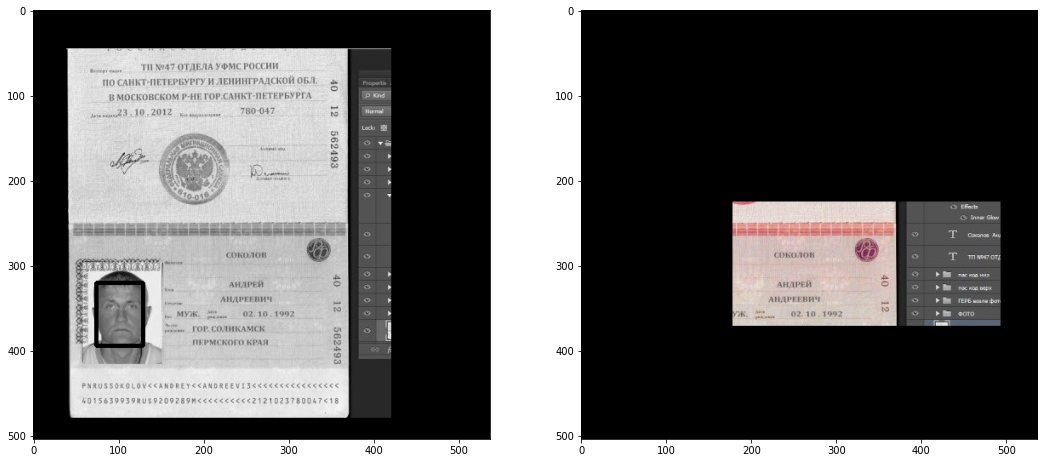

OK! answer= {'Фамилия': 'СОКОЛОВ', 'Имя': 'АНДРЕИ', 'Отчество': 'АНДРЕЕНИЧ'}
----------------------------------------
1/1 [==============================] - 0s 28ms/step


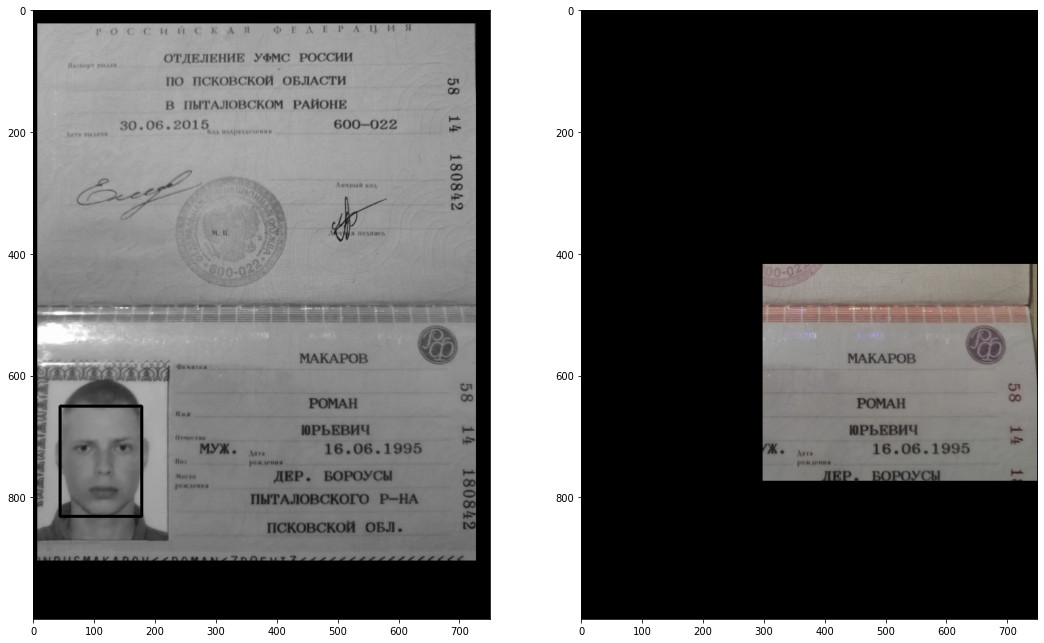

OK! answer= {'Фамилия': 'МАКАРОВ', 'Имя': 'РОМАН', 'Отчество': 'ЮРЬЕВИЧ'}
----------------------------------------
1/1 [==============================] - 0s 40ms/step


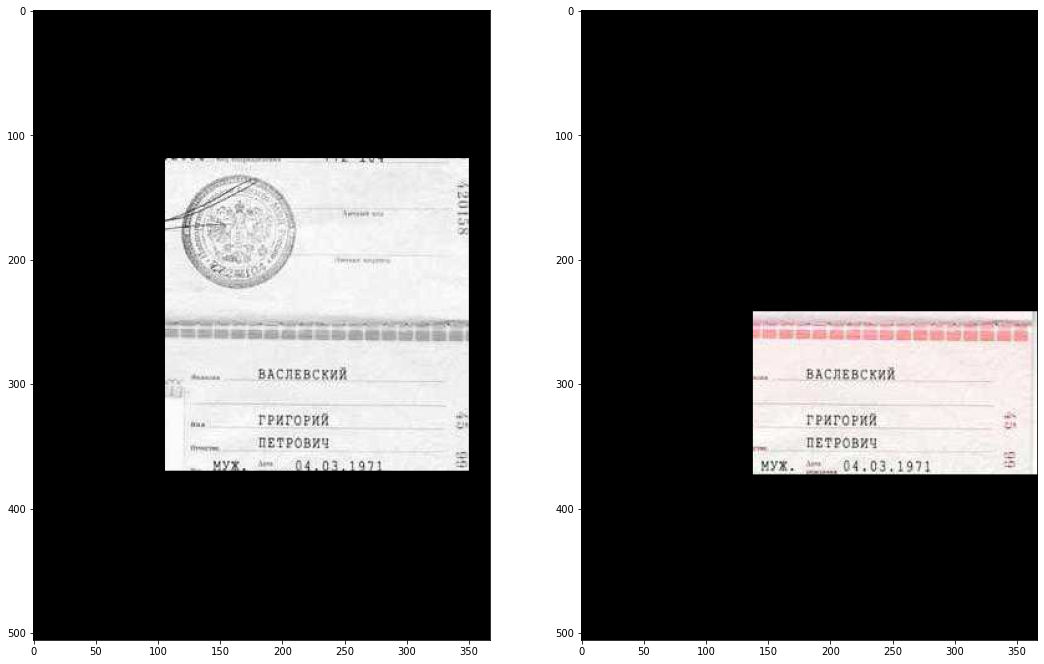

OK! answer= {'Фамилия': 'ВАСЛЕВСКИЯ', 'Имя': 'ГРКГОРЖЯ', 'Отчество': 'ПЕТРОВИЦ'}
----------------------------------------
1/1 [==============================] - 0s 49ms/step


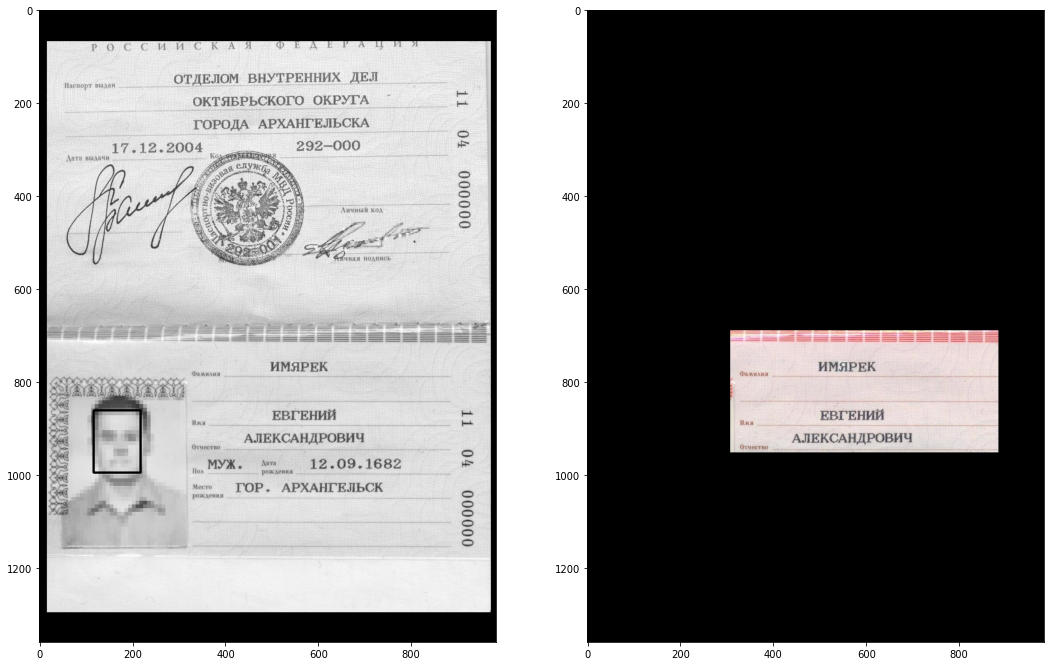

OK! answer= {'Фамилия': 'ИМЯРЕК', 'Имя': 'ЕВГЕНИЙ', 'Отчество': 'АЛЕКСАНДРОВИЧ'}
----------------------------------------
1/1 [==============================] - 0s 37ms/step


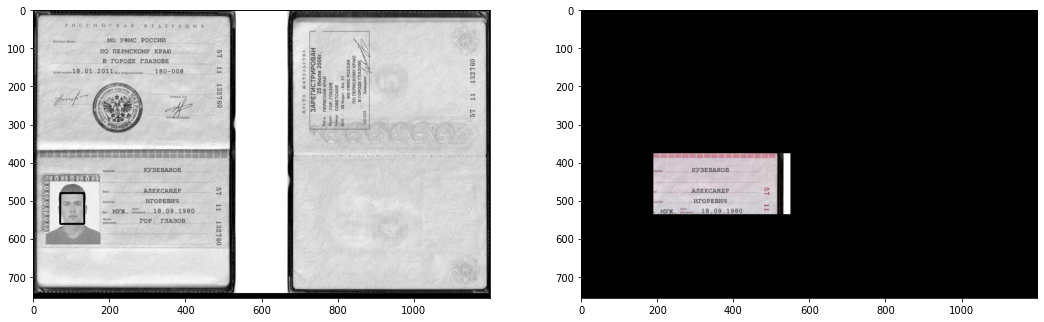

OK! answer= {'Фамилия': 'КУЗЕВАНОВ', 'Имя': 'АЛЕКСАНДР', 'Отчество': 'ИГОРЕВИЧ'}
----------------------------------------
1/1 [==============================] - 0s 58ms/step


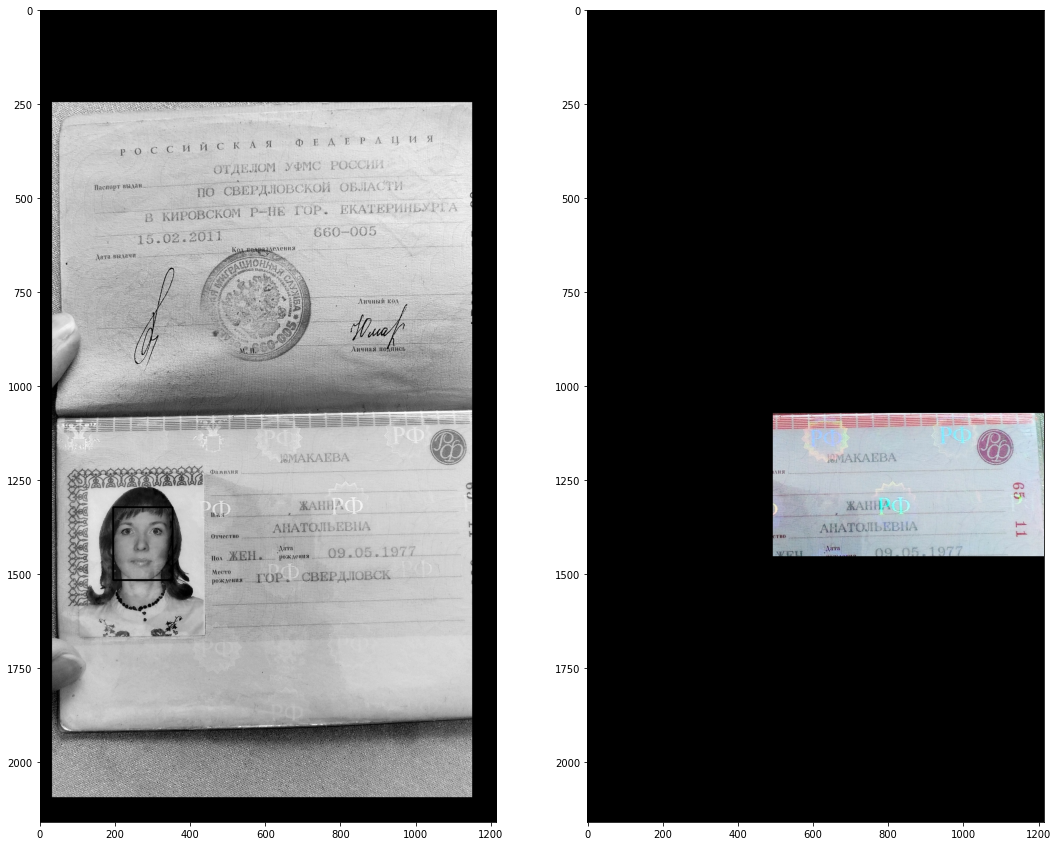

NameNotFoundError <> file_name, texts: 9.jpeg [([[589, 1109], [682, 1109], [682, 1170], [589, 1170]], '5а', 0.018480074415621446), ([[934, 1104], [1028, 1104], [1028, 1160], [934, 1160]], 'РФ', 0.9998688415268309), ([[629, 1173], [827, 1173], [827, 1209], [629, 1209]], 'ЗМАКАЕВА', 0.248599807484206), ([[497, 1223], [529, 1223], [529, 1237], [497, 1237]], 'лия', 0.9264630048042338), ([[1127, 1251], [1167, 1251], [1167, 1307], [1127, 1307]], 'с', 0.8324159104233786), ([[685, 1301], [777, 1301], [777, 1337], [685, 1337]], 'ЖАНН', 0.32086890935897827), ([[768, 1290], [866, 1290], [866, 1346], [768, 1346]], 'РРФ', 0.9841076592361885), ([[616, 1355], [883, 1355], [883, 1397], [616, 1397]], 'АНАТОЛЬЕВНА', 0.9804577381277528), ([[1135, 1353], [1173, 1353], [1173, 1407], [1135, 1407]], '6', 0.2684134907234501), ([[501, 1395], [531, 1395], [531, 1407], [501, 1407]], 'ТНО', 0.39160811318710864), ([[633, 1423], [675, 1423], [675, 1443], [633, 1443]], 'Дата', 0.9490910768508911), ([[830, 1423], [88

In [ ]:
for file_name in filenames:   
    try:
        texts = convert_image2text(file_name) 
        answer = get_text_result(texts, tr_conf=0.3)  
        print("OK! answer=", answer) 
    except NotFacesFoundError:
        print("Not found face --> aborted")
    except NameNotFoundError as e:
        print("NameNotFoundError <> file_name, texts:", file_name, texts)
    print("--" * 20)

Паспорта Васлевского, Юмакаевой и Соколова читаются плохо, с ошибками. Но порог уверенности модели в этом демонстрационном примере поставлен низким(0.3) - поэтому ошибка выскакивает только на Юмакаевой, остальные 2  прочитаны с опечатками.

## Своя модель распознавания

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!cp  /content/gdrive/MyDrive/lines_w25.tar /content/lines_w25.tar

In [ ]:
!tar -xf /content/lines_w25.tar

In [ ]:
#model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
from tqdm import tqdm, tqdm_notebook
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset, DataLoader
import imgaug as ia
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# general
import cv2
import os
import string
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
txt_files = []
png_files = []
others = []

data_dir = '/content/lines_w25/'

for file_name in os.listdir(data_dir):
    if file_name.endswith('.txt'):
        txt_files.append(file_name)
    elif file_name.endswith('.png'):
        png_files.append(file_name)
    else:
        txt_files.append(file_name)

print([len(x) for x in (txt_files, png_files, others)])
print(len(txt_files ), len(set(txt_files)))
txt_files.sort()
png_files.sort()

print(", ".join(txt_files[:10]))
print(", ".join(png_files[:10]))


[200002, 200002, 0]
200002 200002
0_a.gt.txt, 0_b.gt.txt, 100000_a.gt.txt, 100000_b.gt.txt, 10000_a.gt.txt, 10000_b.gt.txt, 10001_a.gt.txt, 10001_b.gt.txt, 10002_a.gt.txt, 10002_b.gt.txt
0_a.png, 0_b.png, 100000_a.png, 100000_b.png, 10000_a.png, 10000_b.png, 10001_a.png, 10001_b.png, 10002_a.png, 10002_b.png


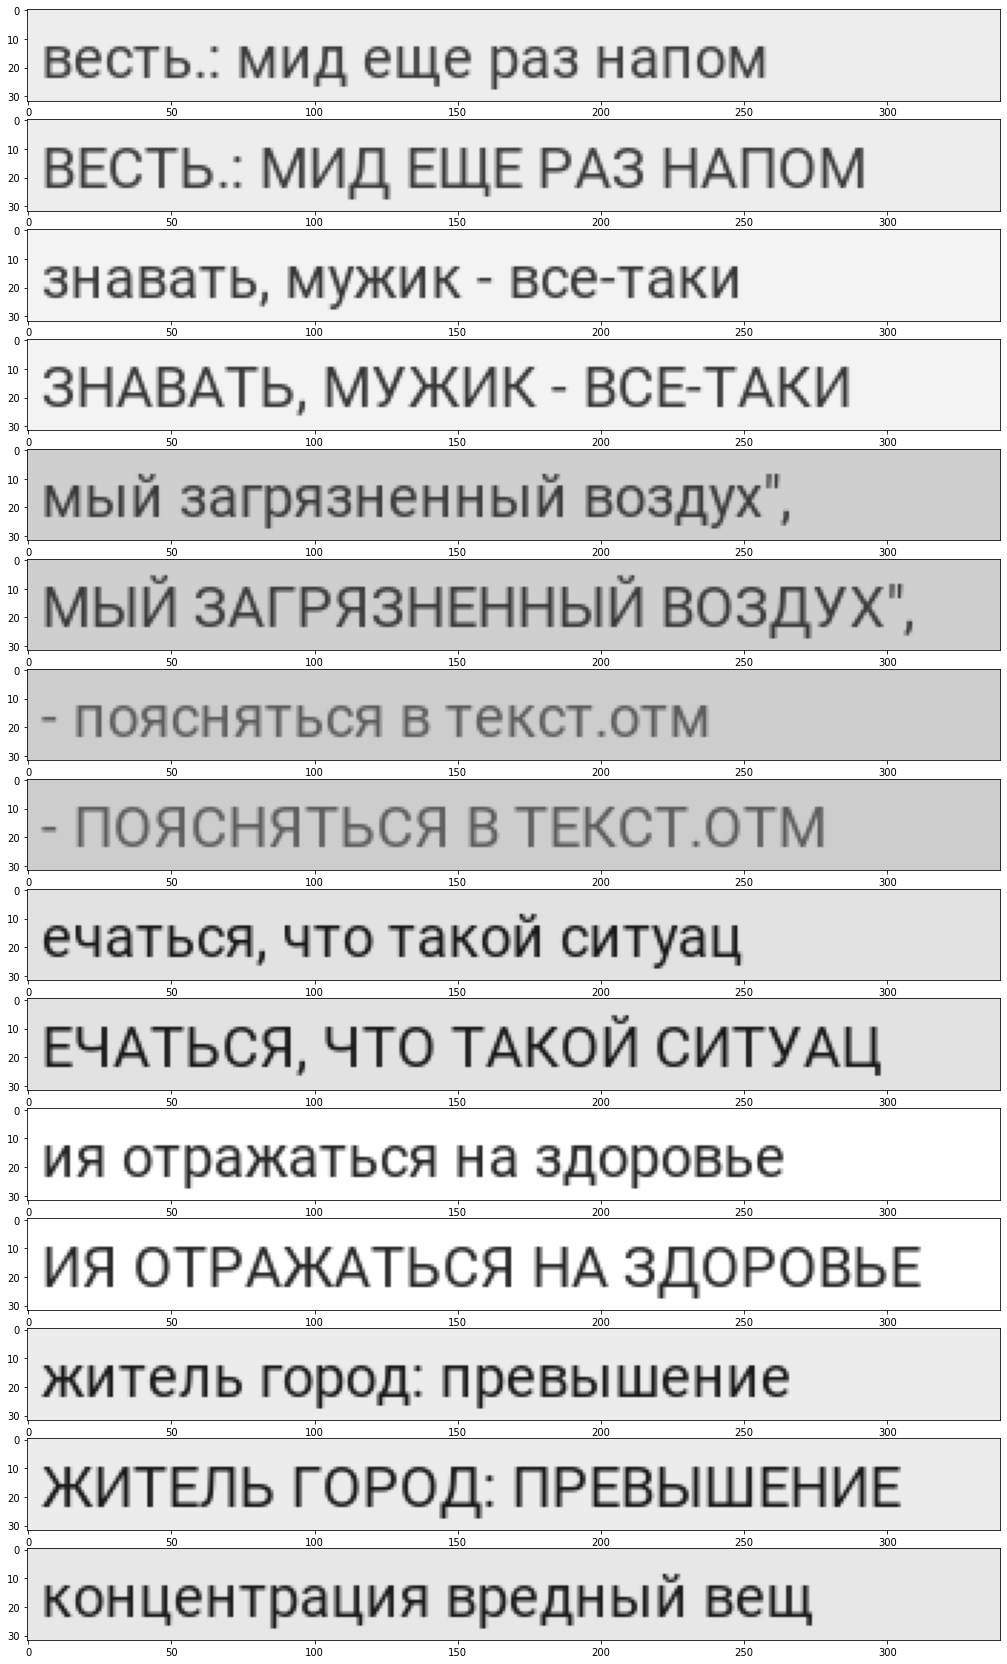

('0_a.png', '0_a.gt.txt', (32, 340, 3), 'весть.: мид еще раз напом', 21760)
('0_b.png', '0_b.gt.txt', (32, 340, 3), 'ВЕСТЬ.: МИД ЕЩЕ РАЗ НАПОМ', 21760)
('100000_a.png', '100000_a.gt.txt', (32, 340, 3), 'знавать, мужик - все-таки', 21760)
('100000_b.png', '100000_b.gt.txt', (32, 340, 3), 'ЗНАВАТЬ, МУЖИК - ВСЕ-ТАКИ', 21760)
('10000_a.png', '10000_a.gt.txt', (32, 340, 3), 'мый загрязненный воздух",', 21760)
('10000_b.png', '10000_b.gt.txt', (32, 340, 3), 'МЫЙ ЗАГРЯЗНЕННЫЙ ВОЗДУХ",', 21760)
('10001_a.png', '10001_a.gt.txt', (32, 340, 3), '- поясняться в текст.отм', 21760)
('10001_b.png', '10001_b.gt.txt', (32, 340, 3), '- ПОЯСНЯТЬСЯ В ТЕКСТ.ОТМ', 21760)
('10002_a.png', '10002_a.gt.txt', (32, 340, 3), 'ечаться, что такой ситуац', 21760)
('10002_b.png', '10002_b.gt.txt', (32, 340, 3), 'ЕЧАТЬСЯ, ЧТО ТАКОЙ СИТУАЦ', 21760)
('10003_a.png', '10003_a.gt.txt', (32, 340, 3), 'ия отражаться на здоровье', 21760)
('10003_b.png', '10003_b.gt.txt', (32, 340, 3), 'ИЯ ОТРАЖАТЬСЯ НА ЗДОРОВЬЕ', 21760)
('1000

In [ ]:
n = 15
labels = []

fig, ax = plt.subplots(n, 1, figsize=(15 * n, 30))
for j in range(n):
    img = cv2.imread(f'/content/lines_w25/{png_files[j]}')
    shape = img.shape
    gray_indent = np.equal(img[:,:, 0], img[:,:, 1]).sum() + np.equal(img[:,:, 2], img[:,:, 1]).sum()
    ax[j].imshow(img, cmap='gray', vmin=0, vmax=255)

    with open(f'/content/lines_w25/{txt_files[j]}') as f:
        txt = f.read().strip()
        labels.append((png_files[j], txt_files[j], shape, txt, gray_indent))

plt.show()
for d in labels:
    print(d)

In [ ]:
total_chars = Counter()
uniq_lengths, uniq_shape = {}, {}
equal_begin = 0
MEAN = 0
STD = 0

zero_lengths = []

for j, file_name in enumerate(txt_files):
    beg = file_name.split('.')[0]
    img_name = png_files[j]
    equal_begin += img_name.startswith(beg + '.')
    img = cv2.imread(f'/content/lines_w25/{img_name}', 0)
    uniq_shape[img.shape] = uniq_shape.get(img.shape, 0) + 1
    img = np.float16(img) / 255
    MEAN += img.mean()
    STD += img.std()
   
    with open(f'/content/lines_w25/{file_name}') as f:
        txt = f.read()[:-1]                                # убрать только перенос, пробелы оставить
    uniq_lengths[len(txt)] = uniq_lengths.get(len(txt), 0) + 1
    if len(txt) <= 3:
        zero_lengths.append(file_name)

    words= txt.split()
    total_chars.update(list(txt))

In [ ]:
for name in zero_lengths[: 20]:
    with open(f'/content/lines_w25/{name}') as f:
        txt = f.read()[:-1]
    print(name, "text:", txt )

print(len(zero_lengths), len(set(zero_lengths)))
for name in zero_lengths:
    beg = name.split('.')[0]
    img_name = beg + ".png"
    png_files.remove(img_name)
    txt_files.remove(name)

1007_a.gt.txt text: ров.
1007_b.gt.txt text: РОВ.
11068_a.gt.txt text: клуб.
11068_b.gt.txt text: КЛУБ.
11642_a.gt.txt text: 
11642_b.gt.txt text: 
11790_a.gt.txt text: 
11790_b.gt.txt text: 
11791_a.gt.txt text: 
11791_b.gt.txt text: 
12047_a.gt.txt text: сеан.
12047_b.gt.txt text: СЕАН.
12620_a.gt.txt text: й кб.
12620_b.gt.txt text: Й КБ.
1341_a.gt.txt text: .
1341_b.gt.txt text: .
13548_a.gt.txt text: 
13548_b.gt.txt text: 
14157_a.gt.txt text: "ни".
14157_b.gt.txt text: "НИ".
1224 1224


Вот это было неожиданно - 854 изображениям соответствуют  пустые текстовые файлы!

In [ ]:
# print(len(total_shars), equal_begin / len(txt_files))
# uniq_lengths = sorted(uniq_lengths.items())
# uniq_shape = sorted(uniq_shape.items())
# MEAN /= len(txt_files)
# STD /= len(txt_files)
# print("uniq_shape:", uniq_shape)
# print("uniq_lengths:", uniq_lengths)
# MEAN, STD

92 1.0
uniq_shape: [((32, 340), 200002)]
uniq_lengths: [(0, 854), (1, 64), (2, 74), (3, 64), (4, 96), (5, 72), (6, 60), (7, 70), (8, 60), (9, 56), (10, 74), (11, 56), (12, 78), (13, 92), (14, 66), (15, 66), (16, 68), (17, 50), (18, 64), (19, 68), (20, 98), (21, 140), (22, 260), (23, 4384), (24, 47282), (25, 145686)]


(0.8184756311616571, 0.18888870380247613)

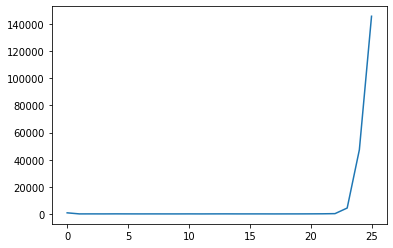

In [ ]:
x, y = zip(*sorted(uniq_lengths.items()))
plt.plot(x, y)
# uniq_lengths

73142 ва держаться на вполне ко (32, 340)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1443: UserWarning: The parameter 'fillcolor' is deprecated since 0.12 and will be removed in 0.14. Please use 'fill' instead.
  "The parameter 'fillcolor' is deprecated since 0.12 and will be removed in 0.14. "


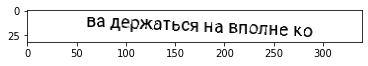

In [ ]:
def rand_dataset():
    j = 73142 #np.random.randint(0, len(txt_files)) #                   j = 164031
    
    with open(f'/content/lines_w25/{txt_files[j]}') as f:
        txt = f.read().strip()
    img = cv2.imread(f'/content/lines_w25/{png_files[j]}', 0)
    bg = img[-3:, :].mean()
    img = transforms.ToPILImage()(img) 

    img = transforms.RandomAffine(8, translate=(0.2, 0.15,), scale=(0.8, 1.1), fillcolor=bg, fill=bg)(img)
    img = transforms.ToTensor()(img).squeeze(0).numpy()
    # sep = count_sep(img, txt)

    plt.imshow(img, cmap='gray')
    print(j, txt, img.shape)


rand_dataset()

Dataloader

In [ ]:
IMG_H, IMG_W = (32, 340)
CNN_OUTP_H = 5
cnn_output_width=82
MEAN_IMG = 0.8185
STD_IMG = 0.1889
CHARS = list(' !"()*,-.0123456789:;<>?[]ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё')
N_CLASSES = len(CHARS) + 1
BLANK = 0

DEVICE = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
if not torch.cuda.is_available():
    print("А где же ГПУ?")

''.join(CHARS)

' !"()*,-.0123456789:;<>?[]ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё'

In [ ]:
class ImgTextData(Dataset):
    def __init__(self, text_files, img_files, ind_labels, text_size=25, mode='val'):
        super().__init__()
        self.img_files = img_files
        self.text_files = text_files
        self.ind_labels = ind_labels
        self.len_ = len(self.text_files)
        self.mode = mode
        self.text_size = text_size


    def __len__(self):
        return self.len_

    def labels(self, txt):
        return [self.ind_labels.index(ch) + 1 for ch in txt]


    def __getitem__(self, index):
        img = cv2.imread(f'/content/lines_w25/{self.img_files[index]}', 0)
        bg = img[-3:, :].mean()

        if self.mode == 'train':
            img = transforms.ToPILImage()(img)
            transform_tr = transforms.Compose([
        #                     # transforms.RandomApply([
        #                     #                         transforms.RandomAffine(8, translate=(0.2, 0.15), scale=(0.8, 1.1), fillcolor=bg, fill=bg), 
        #                     #                         transforms.RandomAffine(8, translate=(0.2, 0.15), scale=(0.8, 1.1), fillcolor=bg, fill=bg)
        #                     #                         ]),
                            transforms.GaussianBlur(kernel_size=7)
            ])
            img = transform_tr(img)

        x = transforms.ToTensor()(img)
        x = transforms.Normalize(mean=[MEAN_IMG], std=[STD_IMG])(x)

        with open(f'/content/lines_w25/{self.text_files[index]}') as f:
            txt = f.read()[:-1]
        target_length = torch.IntTensor([len(txt)])
        # mask = torch.LongTensor([1] * len(txt) + [0] * (self.text_size - len(txt))
        y = self.labels(txt) + [BLANK] * (self.text_size - target_length) 
        y = torch.LongTensor(y)
        return (x, (y, target_length))


In [ ]:
print(len(txt_files), len(png_files))
png_files.sort()
txt_files.sort()

198778 198778


In [ ]:
indexes = np.arange(len(txt_files)) 
np.random.shuffle(indexes)
test_len = int(len(txt_files) * 0.15)
test_ind = indexes[: test_len]
val_len = int((len(txt_files) - test_len) * 0.15)
val_ind = indexes[test_len: test_len + val_len]
train_ind = indexes[test_len + val_len:]

test_txt, test_png = [txt_files[j] for j in test_ind], [png_files[j] for j in test_ind]
val_txt, val_png = [txt_files[j] for j in val_ind], [png_files[j] for j in val_ind]
train_txt, train_png = [txt_files[j] for j in train_ind], [png_files[j] for j in train_ind]

train_dataset = ImgTextData(train_txt, train_png, CHARS, mode='train')
val_dataset = ImgTextData(val_txt, val_png, CHARS, mode='val')
test_dataset = ImgTextData(test_txt, test_png, CHARS, mode='val')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

In [ ]:
list(map(len, (test_txt, test_png, train_txt, train_png, val_txt, val_png)))

[29816, 29816, 143618, 143618, 25344, 25344]

torch.Size([1, 32, 340]) tensor(-3.9178) tensor(-0.6123) tensor(-0.1395)
torch.Size([64, 25]) torch.Size([64, 1])
tensor([46, 28, 46, 56, 45, 59,  1, 31, 44, 59, 35, 41, 55, 37,  1, 34, 36, 30,
        42, 46, 41, 42, 33,  7,  0]) tensor([24], dtype=torch.int32)


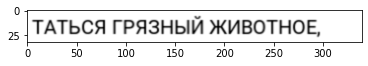

In [ ]:
x, (y, targ_lengths) = next(iter(train_loader))  # images, labels, targ_lengths
im = x[0]
print(im.shape, im.min(), im.mean(), im.max())
print(y.shape, targ_lengths.shape)
print(y[0], targ_lengths[0])
plt.imshow(im.squeeze(0), cmap='gray')
plt.show()

tensor([91, 64, 74, 70,  9,  1, 83, 60, 77, 78, 74,  1, 62, 77, 65,  1, 89, 78,
        74,  1, 74, 73, 70, 74, 71])


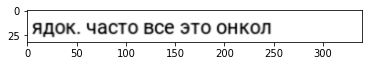

In [ ]:
print(y[19])
plt.imshow(x[19].squeeze(0), cmap='gray')
plt.show()

In [ ]:
class CRNN(nn.Module):
    def __init__(self, gru_hidden_size, gru_num_layers, cnn_output_height, cnn_output_width, num_classes):
        super().__init__()
        self.gru_input_size = cnn_output_height * 64

        self.conv = nn.Sequential( 
                                  nn.Conv2d(1, 32, kernel_size=(3, 3)),
                                  nn.InstanceNorm2d(32),   # вроде лучше чем...   nn.BatchNorm2d(32),
                                  nn.LeakyReLU(),
                                  nn.Conv2d(32, 32, kernel_size=(3, 3)),
                                  nn.MaxPool2d((2, 2)),
                                  nn.InstanceNorm2d(32),
                                  nn.LeakyReLU(),
                                  nn.Conv2d(32, 64, kernel_size=(3, 3)),
                                  nn.InstanceNorm2d(64),
                                  nn.LeakyReLU(),
                                  nn.Conv2d(64, 64, kernel_size=(3, 3)),
                                  nn.MaxPool2d((2, 2)),
                                  nn.InstanceNorm2d(64),
                                  nn.LeakyReLU()
                                 )
        
        self.gru = nn.GRU(self.gru_input_size, gru_hidden_size, gru_num_layers, 
                          batch_first=True, bidirectional=True)
        
        self.classifier = nn.Sequential(
                                nn.Linear(gru_hidden_size * 2, gru_hidden_size),
                                nn.BatchNorm1d(cnn_output_width),
                                nn.ReLU(),
                                nn.Linear(gru_hidden_size, num_classes)
                               )

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.conv(x)
        out = out.view(batch_size, -1, out.shape[-1])  # [batch_size, cnn_output_height * channels_out, T]
        out = out.transpose(2, 1)                      # [batch_size, T, cnn_output_height * channels_out]
        out, _ = self.gru(out)
        return F.log_softmax(self.classifier(out), dim=-1)


In [ ]:
model = CRNN(gru_hidden_size=128, 
             gru_num_layers=2, 
             cnn_output_height=CNN_OUTP_H, 
             cnn_output_width=82,
             num_classes=N_CLASSES
             )
model = model.to(DEVICE)

z = torch.Tensor(np.zeros((32, 340))).unsqueeze(0).unsqueeze(0).to(DEVICE)

outp = model(z)
outp.shape , model.gru_input_size

(torch.Size([1, 82, 93]), 320)

In [ ]:
from torchsummary import summary

summary(model, z.squeeze(0).shape, batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [64, 32, 30, 338]             320
    InstanceNorm2d-2          [64, 32, 30, 338]               0
         LeakyReLU-3          [64, 32, 30, 338]               0
            Conv2d-4          [64, 32, 28, 336]           9,248
         MaxPool2d-5          [64, 32, 14, 168]               0
    InstanceNorm2d-6          [64, 32, 14, 168]               0
         LeakyReLU-7          [64, 32, 14, 168]               0
            Conv2d-8          [64, 64, 12, 166]          18,496
    InstanceNorm2d-9          [64, 64, 12, 166]               0
        LeakyReLU-10          [64, 64, 12, 166]               0
           Conv2d-11          [64, 64, 10, 164]          36,928
        MaxPool2d-12            [64, 64, 5, 82]               0
   InstanceNorm2d-13            [64, 64, 5, 82]               0
        LeakyReLU-14            [64, 64

In [ ]:
# class CNNLayerNorm(nn.Module):
#     def __init__(self, n_feats):
#         super().__init__()
#         self.layer_norm = nn.LayerNorm(n_feats)

#     def forward(self, x):
#                                                # x.shape = (batch, channel, feature, time)
#         x = x.transpose(2, 3).contiguous()     # (batch, channel, time, feature)
#         x = self.layer_norm(x)
#         return x.transpose(2, 3).contiguous()  # (batch, channel, feature, time) 


# class ResidualCNN(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel, dropout, n_feats):
#         super().__init__()
#         self.layer = nn.Sequential(
#                         # CNNLayerNorm(n_feats),
#                         nn.BatchNorm2d(in_channels),
#                         nn.GELU(),
#                         nn.Dropout(dropout),
#                         nn.Conv2d(in_channels, out_channels, kernel, padding=1),      #stride=1
#                         # CNNLayerNorm(n_feats),
#                         nn.BatchNorm2d(out_channels),
#                         nn.GELU(),
#                         nn.Dropout(dropout),
#                         nn.Conv2d(out_channels, out_channels, kernel, padding=1)
#                         )
        
#     def forward(self, x):
#         residual = x               # (batch, channel, feature, time)
#         x = self.layer(x)
#         return x + residual        # (batch, channel, feature, time)


# class CRNN2(nn.Module):

#     def __init__(self, n_cnn_layers, gru_hidden_size, gru_num_layers, cnn_output_height, cnn_output_width, num_classes, dropout=0.1):
#         super().__init__()
#         n_feats = cnn_output_height * 64
#         gru_input_size = cnn_output_height* 32
#         self.cnn = nn.Conv2d(1, 32, 3, stride=2, padding=1) 

#         # n residual cnn layers with filter size of 32
#         self.rescnn_layers = nn.Sequential(*[
#             ResidualCNN(32, 32, kernel=3, dropout=dropout, n_feats=n_feats) 
#             for _ in range(n_cnn_layers)
#         ])

#         self.fully_connected = nn.Linear(n_feats*32, gru_input_size)
#         self.gru = nn.GRU(gru_input_size, gru_hidden_size, gru_num_layers, 
#                           batch_first=True, bidirectional=True)
        
#         self.fc = nn.Sequential(
#                                 nn.Linear(gru_hidden_size * 2, gru_hidden_size),
#                                 nn.BatchNorm1d(cnn_output_width),
#                                 nn.ReLU(),
#                                 nn.Linear(gru_hidden_size, num_classes)
#                                )

#     def forward(self, x):
#         x = self.cnn(x)
#         x = self.rescnn_layers(x)
#         sizes = x.size()
#         x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
#         x = x.transpose(1, 2)                                # (batch, time, feature)
#         x = self.fully_connected(x)
#         out, _ = self.gru(x)
#         return F.log_softmax(self.classifier(out), dim=-1)


In [ ]:
from itertools import groupby


def acc_prediction(y_target, y_pred):
    _, max_index = torch.max(y_pred, dim=-1)                                    # max_index.shape == torch.Size([T, B])
    pred_correct = 0

    for i in range(y_pred.shape[1]):
        raw_prediction = list(max_index[:, i].detach().cpu().numpy())           # len(raw_prediction) == T
        prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != BLANK])
        pred_correct += len(prediction) == len(y_target[i]) and torch.all(prediction.eq(y_target[i]))

    return pred_correct / max_index.shape[1] 


def train_epoh(model, criterion, train_loader, scheduler, optimizer, train_loss, train_acc):
    model.train()
    loss_tr = 0
    tr_acc = 0

    for x_train, (y_train,  target_lengths) in train_loader:
        x_train = x_train.to(DEVICE)                      # .view(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])

        optimizer.zero_grad()
        
        y_pred = model(x_train).permute(1, 0, 2)                            # y_pred.shape == torch.Size([B, T, N_CASSES])

        input_lengths = torch.IntTensor(y_train.shape[0]).fill_(cnn_output_width)
        
        loss = criterion(y_pred, y_train, input_lengths, target_lengths)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 10)  # clip gradients
        optimizer.step()
        if scheduler:
            scheduler.step()
        
        loss_tr += loss.item()
        tr_acc += acc_prediction(y_train, y_pred)

    train_loss.append(loss_tr / len(train_loader))
    train_acc.append(tr_acc / len(train_loader))


def eval_epoh(model, criterion, val_loader, val_loss, val_acc):
    model.eval()
    v_acc = 0
    loss_val = 0
    
    with torch.no_grad():
        for x_val, (y_val, target_lengths) in val_loader:
            x_val = x_val.to(DEVICE)                         #  .view(x_val.shape[0], 1, x_val.shape[1], x_val.shape[2])
            y_pred = model(x_val).permute(1, 0, 2) 

            input_lengths = torch.IntTensor(y_val.shape[0]).fill_(cnn_output_width)
            loss = criterion(y_pred, y_val, input_lengths, target_lengths)

            loss_val += loss.item()
            v_acc += acc_prediction(y_val, y_pred)

    val_loss.append(loss_val / len(val_loader))
    val_acc.append(v_acc / len(val_loader))


In [ ]:
def train(model, epochs, results, scheduler, optimizer, train_loader, val_loader, n_patience, path):
    best_acc = 0
    cnt_bad = 0
    train_loss, train_acc = results["train_loss"], results["train_acc"]
    val_loss, val_acc = results["val_loss"], results["val_acc"]
    train_acc = results["train_acc"]
    val_acc = results["val_acc"]

    criterion = nn.CTCLoss(blank=BLANK, reduction='mean', zero_infinity=True)
    
    for k in range(epochs):
        train_epoh(model, criterion, train_loader, scheduler, optimizer, train_loss, train_acc)
        eval_epoh(model, criterion, val_loader, val_loss, val_acc)

        print(f'epoh= {k + 1}, train_acc={train_acc[-1]: .4}, val_acc={val_acc[-1]: .4} || train_loss= {train_loss[-1]:.5}, val_loss= {val_loss[-1]:.5}')
        
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            model = model.cpu()
            torch.save(model.state_dict(), path)
            model = model.to(DEVICE)
            cnt_bad = 0

        else:
            cnt_bad += 1


In [ ]:
lr = 0.0005
epochs= 20
n_patience = 5
path = '/content/model.pth'

optimizer = optim.AdamW(model.parameters(), lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
	max_lr=lr,
	steps_per_epoch=int(len(train_loader)),
	epochs=epochs,
	anneal_strategy='linear')

# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
results = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}

train(model, epochs, results, scheduler, optimizer, train_loader, val_loader, n_patience, path)

epoh= 1, train_acc= 0.2037, val_acc= 0.6995 || train_loss= 2.4321, val_loss= 0.051629
epoh= 2, train_acc= 0.7181, val_acc= 0.7244 || train_loss= 0.018334, val_loss= 0.0063019
epoh= 3, train_acc= 0.7255, val_acc= 0.7271 || train_loss= 0.0048037, val_loss= 0.0022565
epoh= 4, train_acc= 0.7269, val_acc= 0.7281 || train_loss= 0.0026452, val_loss= 0.0014366
epoh= 5, train_acc= 0.7289, val_acc= 0.7287 || train_loss= 0.0015006, val_loss= 0.0011386
epoh= 6, train_acc= 0.7282, val_acc= 0.7289 || train_loss= 0.0016937, val_loss= 0.00098062
epoh= 7, train_acc= 0.729, val_acc= 0.7298 || train_loss= 0.0012532, val_loss= 0.00072428
epoh= 8, train_acc= 0.7293, val_acc= 0.7301 || train_loss= 0.001019, val_loss= 0.00055272
epoh= 9, train_acc= 0.7301, val_acc= 0.7304 || train_loss= 0.00084018, val_loss= 0.00061515
epoh= 10, train_acc= 0.7311, val_acc= 0.7301 || train_loss= 0.00057123, val_loss= 0.00052332
epoh= 11, train_acc= 0.731, val_acc= 0.7305 || train_loss= 0.00061494, val_loss= 0.00049341
epoh= 1

In [ ]:
!cp /content/model.pth /content/gdrive/MyDrive/model.pth

In [ ]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
def test_net(model, test_loader):
    model.eval()
    v_acc = 0
    loss_val = 0
    
    for x_val, (y_val, target_lengths) in test_loader:
        x_val = x_val.to(DEVICE)                         #  .view(x_val.shape[0], 1, x_val.shape[1], x_val.shape[2])
        y_pred = model(x_val).permute(1, 0, 2) 
        v_acc += acc_prediction(y_val, y_pred)

    print("test_accuracy:", v_acc / len(test_loader))

test_net(model, test_loader)

test_accuracy: tensor(0.7332)


In [ ]:
predictions = []

x, (y, ln_targ) = next(iter(test_loader))
x = x.to(DEVICE)         # .view(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
y_pred = model(x)
_, max_index = torch.max(y_pred, dim=-1)                      # max_index.shape == torch.Size([T, B])
print(max_index.shape)
for i in range(y.shape[0]):
    raw_prediction = list(max_index[i, :].detach().cpu().numpy())  # len(raw_prediction) == T
    prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != BLANK])
    predictions.append(prediction)
    if not (i % 10):
        print(raw_prediction)

for j, pred in  enumerate(predictions):
    txt = ''.join([CHARS[d - 1] for d in pred.tolist() if d > 0])
    txt_orig = ''.join([CHARS[d - 1] for d in y[j].tolist() if d > 0])
    if txt != txt_orig:
        print("not equal:", txt, '||', txt_orig)
    elif j < 10: 
        print(txt, '||', txt_orig)


torch.Size([64, 82])
[0, 73, 0, 0, 65, 1, 1, 0, 77, 0, 83, 0, 0, 68, 0, 78, 78, 0, 60, 0, 0, 78, 0, 0, 88, 1, 1, 0, 77, 0, 74, 0, 0, 62, 0, 0, 65, 0, 78, 0, 0, 77, 0, 0, 70, 0, 68, 0, 0, 69, 0, 1, 1, 77, 0, 0, 74, 0, 0, 71, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 28, 0, 0, 35, 0, 0, 30, 0, 0, 36, 0, 0, 30, 30, 0, 0, 28, 0, 46, 46, 0, 0, 56, 0, 0, 45, 0, 0, 59, 0, 1, 1, 0, 45, 0, 0, 46, 0, 0, 44, 0, 0, 33, 0, 0, 0, 40, 0, 0, 36, 36, 0, 46, 46, 0, 0, 33, 0, 0, 39, 0, 0, 56, 0, 0, 41, 41, 0, 0, 42, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 42, 0, 1, 1, 0, 42, 0, 0, 41, 0, 0, 0, 28, 0, 1, 0, 29, 0, 0, 55, 0, 0, 0, 46, 46, 0, 0, 56, 0, 1, 0, 43, 0, 0, 0, 44, 0, 0, 36, 0, 0, 35, 0, 0, 41, 41, 0, 0, 28, 0, 0, 30, 0, 0, 28, 0, 0, 46, 0, 0, 56, 0, 1, 1, 0, 29, 0, 0, 28, 0, 0, 41, 41, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 81, 0, 74, 0, 0, 78, 0, 65, 0, 0, 78, 0, 0, 88, 7, 7, 1, 83, 0, 0, 78, 0, 0, 74, 0, 0, 61, 0, 87, 0, 0, 1, 1, 0, 62, 0, 1, 0, 72, 0, 0, 74, 0, 0, 69, 0, 1, 1, 77

Качество на тесте в тех же границах, что и трейн и валидация. Возможно(!!!) все еще есть проблеммы с датасетом- совершенно неожиданно выявил 854 пустых текстовых файла, которые соответствовали вполне содержательным изображениям. Может нужно поудалять еще что-то, и одновременно:
- аугментация кажется слабой, 
- сетку можно попробовать усложнить, раз она обучается...
Но это все - следующие этапы. Пока что на повестке "скрестить ужа с ежом" - дефолтный детектор из open-cv с обученным recognizer... 